In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation
import class_definitions as cd
import function_definitions as fd
import fish_kinematics as fk
import airfoil as ar

%matplotlib inline

The purpose of this notebook is to model the motion of a flapping fish in python but in a way that can be directly translated to an Ansys Fluent UDF function

First we use the airfoil functions to make a NACA0012 airfoil

A fish body can be modeled using the function **naca4(x, t, c, m=0.0, p=0.30, a4=True)** where, 
    **x** is a 1D numpy array of x-coordinates, 
    **c** is the chord length,
    **t** is the maximum thickness,
    **m** is the maximum camber (defaul is symmetric),
    **p** is the location of maximum camber (should be a non-zero number), and 
    **a4** determines if it has an open or closed edge.

In [2]:
chord = 1.0
# half-cosine spacing
beta = np.linspace(0, np.pi, 100)
#dx = (0.5*(1-np.cos(beta)))
# uniform spacing
dx = np.linspace(0.0, chord, 100)
X, Y = ar.naca4(dx, 0.12, 0.0, 0.30, True, chord)
x, y = ar.convert_to_coordinates(X, Y)

(-0.1, 0.1)

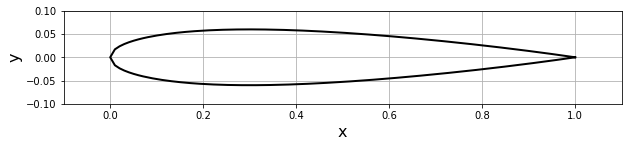

In [3]:
# plot geometry
width = 10
plt.figure(figsize=(width, width))
plt.grid()
plt.xlabel('x', fontsize=16)
plt.ylabel('y', fontsize=16)
plt.plot(x, y, color='k', linestyle='-', linewidth=2)
plt.axis('scaled')
plt.xlim(-0.1, 1.1)
plt.ylim(-0.1, 0.1)

Output airfoil to a file for geometry import

In [4]:
output_file = './naca0012.csv'
BL = 0.2553

if os.path.exists(output_file):
    os.remove(output_file)

# for spaceclaim coordinates
#output_data = np.array(list(zip(np.zeros(len(x)),x*BL*1000, y*BL*1000)))
#np.savetxt(output_file, output_data, delimiter=',', fmt='%f', header='Polyline=True' )

# for design modeler coordinates
#output_data = np.array(list(zip(np.ones(len(x)),np.arange(1, len(x), 1), x*BL*1000,y*BL*1000,np.zeros(len(x)))))
#np.savetxt(output_file, output_data, delimiter=',', fmt='%f', header='Group, Points, X-coord, Y-coord, Z-coord')

Motion as determined by Zhu et al.

- A_h = 0.05 BL
- A_t = 0.15 BL
- x_pivot = 0.3 BL
- frequency = 2.477 Hz
- velocity = 0.3478 ms^-1
- Strouhal = 1.136925

In [5]:
x_pivot = 0.75
x_tail = 1.0
A_t = 0.2
A_p = 0.106
A_h = 0.02

# solving for the coefficients
X = np.array([[1, 0, 0],[1, x_pivot, x_pivot**2], [1, x_tail, x_tail**2]])
A = np.array([[A_h], [A_p], [A_t]])
C = np.linalg.solve(X, A)
print(C)

[[ 0.02      ]
 [-0.08133333]
 [ 0.26133333]]


In [6]:
def carangiform(t, x, amplitude, length, waveNumber, omega):
    x_bl = x/length
    localAmplitude = amplitude[0] * (1 + (x_bl - 1) * amplitude[1] + (np.power(x_bl,2) - 1) * amplitude[2])

    return localAmplitude, localAmplitude * np.sin(waveNumber*x_bl - omega*t) * length

In [7]:
def anguilliform_maertens(t, x, amplitude, length, waveNumber, omega):
    x_bl = x/length
    localAmplitude = amplitude[0] * (1 + (x_bl - 1) * amplitude[1] + (np.power(x_bl,2) - 1) * amplitude[2])

    return localAmplitude, localAmplitude * np.sin(waveNumber*x_bl - omega*t) * length

In [8]:
def anguilliform_tytell(t, x, amplitude, length, waveNumber, omega):
    x_bl = x/length
    localAmplitude = amplitude[0]*np.exp(amplitude[1]*(x_bl-1))

    return localAmplitude, localAmplitude * np.sin(waveNumber*x_bl - omega*t) * length

In [9]:
def carangiform_tail(t, x, amplitude, length, waveNumber, omega, pivot, angle, phase):
    x_bl = x/length
    indexes = np.where(x_bl < pivot)[0]
    mask = np.ones(x_bl.size, dtype=bool)
    mask[indexes]=False
    
    x_body = x_bl[indexes]
    x_tail = x_bl[mask]
    x_tail = x_tail - pivot
    
    localAmplitude = amplitude[0] * (1 + (x_bl - 1) * amplitude[1] + (np.power(x_bl,2) - 1) * amplitude[2])
    
    y_body = localAmplitude * np.sin(waveNumber*x_body - omega*t) * length
    
    # -------------------------------------------------------------
    # Solve for the tail    
    theta_max = np.radians(phase)
    phi = np.radians(angle)
       
    theta = theta_max * np.sin((omega * t) - (waveNumber * pivot) - phi)
    
    y_tail = (x_tail * 2.0 * (1/(np.cos(theta))) * t * theta) * length

    return np.append(y_body, y_tail)

(-0.15, 0.15)

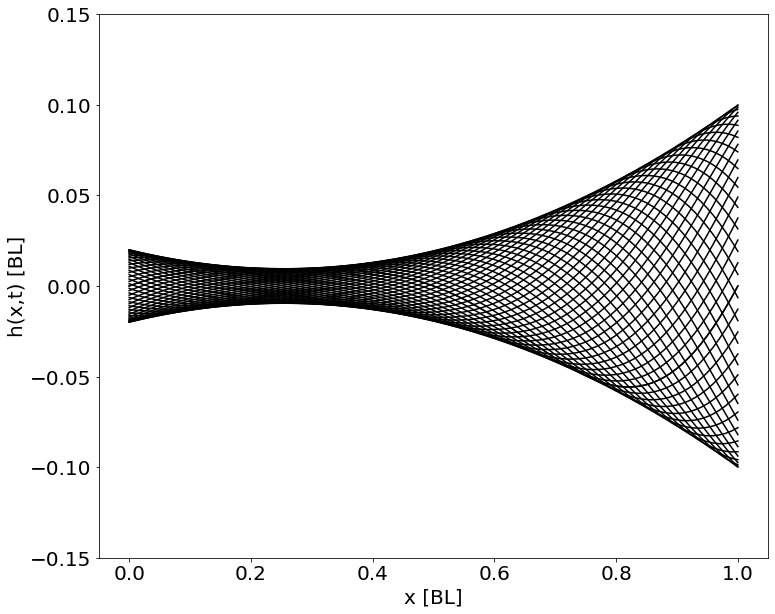

In [10]:
plt.rcParams.update({'font.size':20})
amplitude_ = np.array([0.1, -0.825, 1.625])
length_ = 0.225
St = 0.3
U = 1.0
A_p2p = 0.2
f = St * U / A_p2p
T = 1/f
omega_ = 2 * np.pi * f
lam = 1.0
waveNumber_ = 2*np.pi/lam

time = np.linspace(0, 1*(1/f), 50)

x = np.linspace(0, length_, 100)
x_bl = x / length_

fig1, ax1 = plt.subplots(figsize=(12,10))

for i, t in enumerate(time):
    amp, y = carangiform(t, x, amplitude_, length_, waveNumber_, omega_)
    ax1.plot(x/length_, y/length_, 'k', label=str(np.round(t/T, 3)))

ax1.set_xlabel('x [BL]')
ax1.set_ylabel('h(x,t) [BL]')
ax1.set_ylim([-0.15, 0.15])
#ax1.legend(title='t / $\\tau$', ncol=6, bbox_to_anchor=(1.02, 1.15))

(-0.15, 0.15)

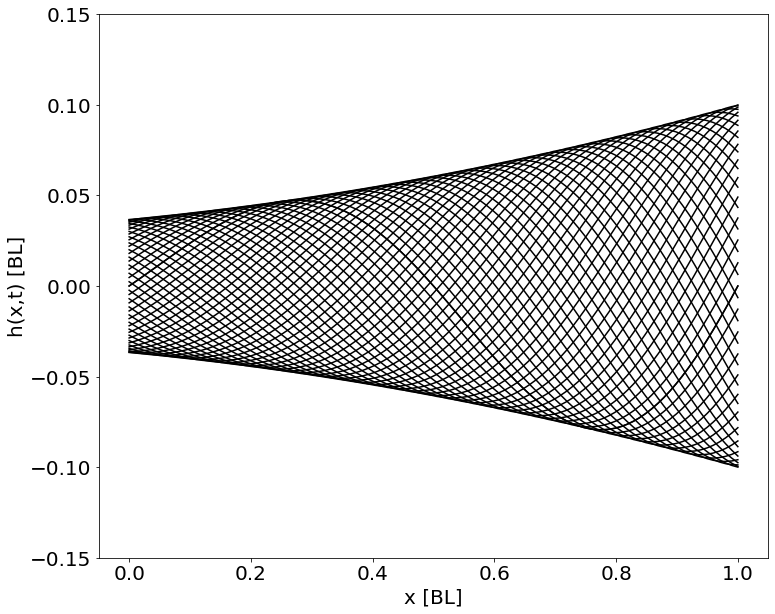

In [11]:
amplitude_ = np.array([0.1, 0.323, 0.310])
length_ = 0.225
St = 0.3
U = 1.0
A_p2p = 0.2
f = St * U / A_p2p
T = 1/f
omega_ = 2 * np.pi * f
lam = 1.0
waveNumber_ = 2*np.pi/lam

time = np.linspace(0, 1*(1/f), 50)

x = np.linspace(0, length_, 100)

fig2, ax2 = plt.subplots(figsize=(12,10))

for i, t in enumerate(time):
    amp, y = anguilliform_maertens(t, x, amplitude_, length_, waveNumber_, omega_)
    ax2.plot(x/length_, y/length_, 'k', label=str(np.round(t/T, 3)))

ax2.set_xlabel('x [BL]')
ax2.set_ylabel('h(x,t) [BL]')
ax2.set_ylim([-0.15, 0.15])
#ax2.legend(title='t / $\\tau$', ncol=6, bbox_to_anchor=(1.02, 1.15))

(-0.15, 0.15)

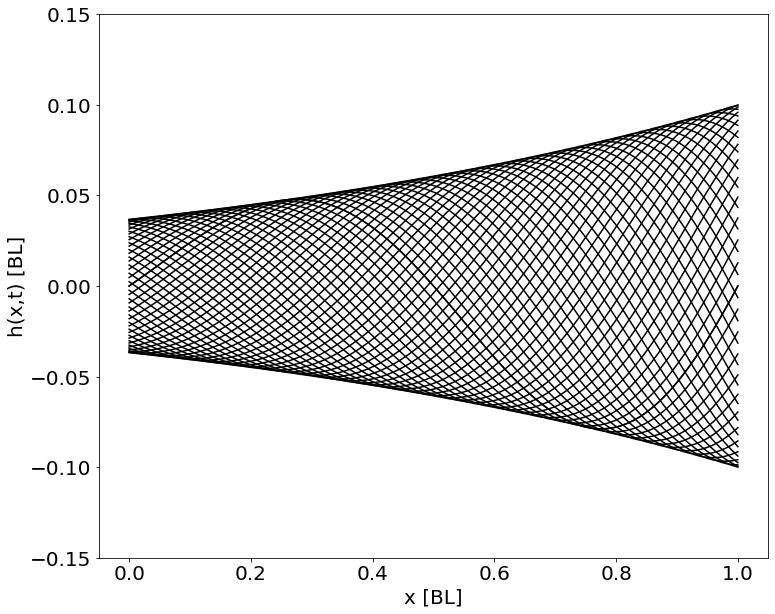

In [14]:
amplitude_ = np.array([0.1, 1, 0])
length_ = 0.225
St = 0.3
U = 1.0
A_p2p = 0.2
f = St * U / A_p2p
T = 1/f
omega_ = 2 * np.pi * f
lam = 1.0
waveNumber_ = 2*np.pi/lam

time = np.linspace(0, 1*(1/f), 50)

x = np.linspace(0, length_, 100)

fig3, ax3 = plt.subplots(figsize=(12,10))

for i, t in enumerate(time):
    amp, y = anguilliform_tytell(t, x, amplitude_, length_, waveNumber_, omega_)
    ax3.plot(x/length_, y/length_, 'k', label=str(np.round(t/T, 3)))

ax3.set_xlabel('x [BL]')
ax3.set_ylabel('h(x,t) [BL]')
ax3.set_ylim([-0.15, 0.15])
#ax3.legend(title='t / $\\tau$', ncol=6, bbox_to_anchor=(1.02, 1.15))

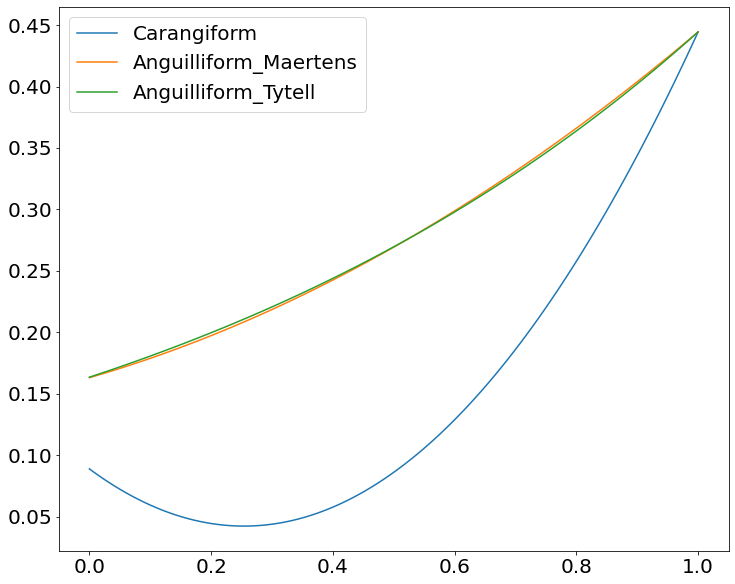

In [20]:
length_ = 0.225
St = 0.3
U = 1.0
A_p2p = 0.2
f = St * U / A_p2p
T = 1/f
omega_ = 2 * np.pi * f
lam = 1.0
waveNumber_ = 2*np.pi/lam

x = np.linspace(0, length_, 100)

amplitude_carang, _ = carangiform(0, x, np.array([0.1, -0.825, 1.625]), length_, waveNumber_, omega_)
amplitude_maertens, _ = anguilliform_maertens(0, x, np.array([0.1, 0.323, 0.310]), length_, waveNumber_, omega_)
amplitude_tytell, _ = anguilliform_tytell(0, x, np.array([0.1, 1.0, 0]), length_, waveNumber_, omega_)

fig4, ax4 = plt.subplots(figsize=(12,10))
ax4.plot(x/length_, amplitude_carang, label='Carangiform')
ax4.plot(x/length_, amplitude_maertens, label='Anguilliform_Maertens')
ax4.plot(x/length_, amplitude_tytell, label='Anguilliform_Tytell')

ax4.legend()


